# LIBRARIES

In [1]:
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Data Preprocessing

In [2]:
df = pd.read_csv("balanced_audio_dataset.csv")
df

,Emotion,Path
0,neutral,RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,neutral,RAVDESS/Actor_01/03-01-02-01-01-01-01.wav
...,...,...
13457,neutral,augmented_data/neutral/03-01-02-02-02-02-01_pi...
13458,neutral,augmented_data/neutral/03-01-01-01-01-01-02_st...
13459,neutral,augmented_data/neutral/03-01-01-01-01-01-02_pi...
13460,neutral,augmented_data/neutral/03-01-01-01-01-02-02_st...


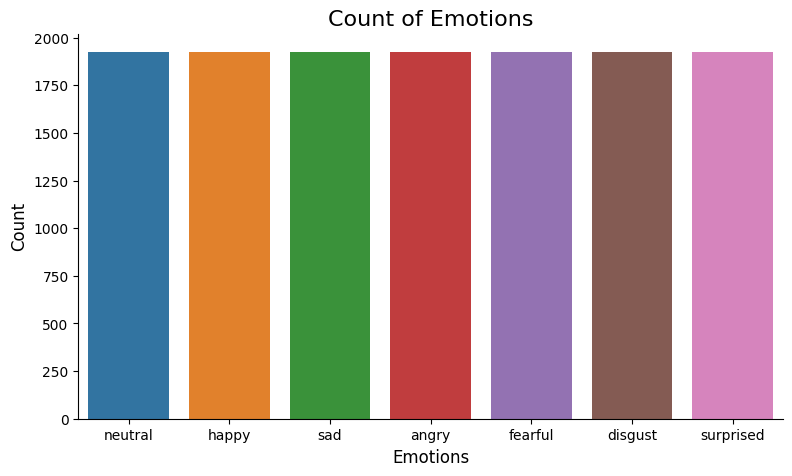

In [3]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(121)
plt.title('Count of Emotions', size=16)
sns.countplot(x=df["Emotion"], hue=df["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Data Augmentation


In [4]:
def noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.randn(len(data))

def stretch(data, rate=random.uniform(0.9, 1.1)):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sr, n_steps=random.randint(-2, 2)):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def augment_audio(y, sr):
    return [
        noise(y),
        stretch(y),
        pitch(y, sr=sr)
    ]

### Data Augmentation example

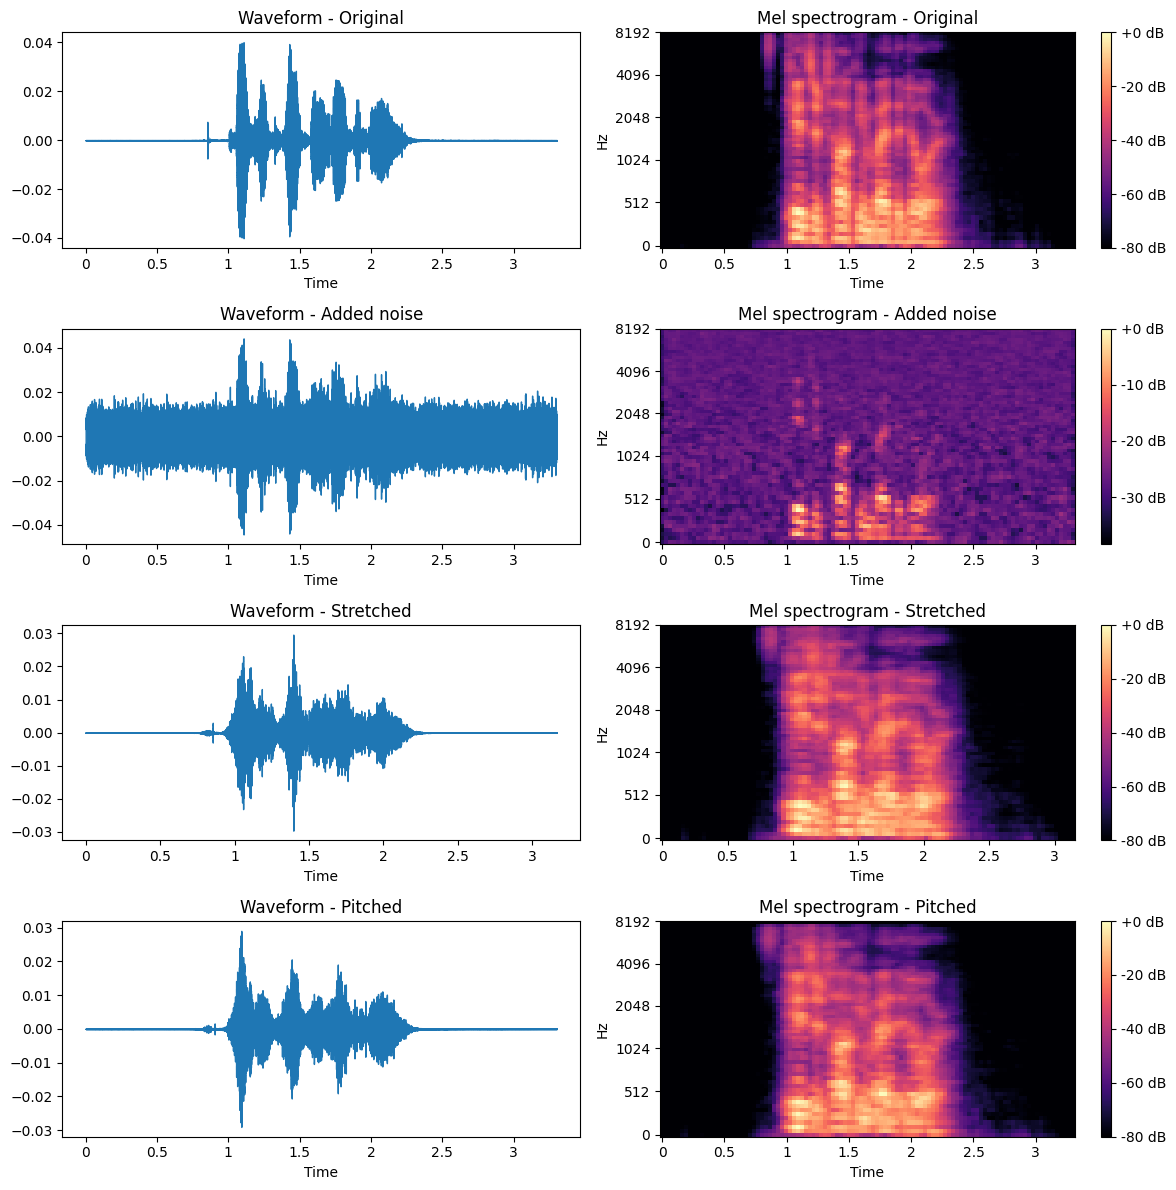

Original Audio:


Added Noise Audio:


Stretched Audio:


Pitched Audio:


In [5]:
example_file = df["Path"].iloc[0]
y, sr = librosa.load(example_file, sr=16000)

added_noise, stretched, pitched = augment_audio(y, sr)

plt.figure(figsize=(12, 12))
for i, (title, data) in enumerate([
    ("Original", y),
    ("Added noise", added_noise),
    ("Stretched", stretched),
    ("Pitched", pitched)
]):
    # Waveform
    plt.subplot(4, 2, 2 * i + 1)
    librosa.display.waveshow(data, sr=sr)
    plt.title(f"Waveform - {title}")

    # Mel spectrogram
    plt.subplot(4, 2, 2 * i + 2)
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=64)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.f dB")
    plt.title(f"Mel spectrogram - {title}")

plt.tight_layout()
plt.show()

# Play the examples
print("Original Audio:")
display(Audio(y, rate=sr))

print("Added Noise Audio:")
display(Audio(added_noise, rate=sr))

print("Stretched Audio:")
display(Audio(stretched, rate=sr))

print("Pitched Audio:")
display(Audio(pitched, rate=sr))

# Feature Extraction


In [6]:
def audio_to_melspectrogram_3d(y, sr=16000, n_mels=64, frame_length=2.0, fixed_n_frames=8, fixed_time_steps=65):
    """
    Convert audio waveform to a 3D array of mel-spectrograms with fixed shape.

    Args:
        y: NumPy array of audio waveform (shape: (n_samples,))
        sr: Sampling rate (default: 16000 Hz)
        n_mels: Number of mel bands (default: 64)
        frame_length: Length of each frame in seconds (default: 2.0)
        fixed_n_frames: Desired number of frames in output (default: 10)
        fixed_time_steps: (default:)

    Returns:
        NumPy array of shape (fixed_n_frames, n_mels, time_steps, channels=1)
    """
    # Normalize amplitude
    y = librosa.util.normalize(y)

    # Calculate samples per frame
    samples_per_frame = int(frame_length * sr)

    # Split audio into frames
    duration = len(y) / sr
    total_frames = int(np.ceil(duration / frame_length))  # Round up to include partial frames
    frames = []

    for i in range(total_frames):
        start = i * samples_per_frame
        end = min(start + samples_per_frame, len(y))
        y_frame = y[start:end]

        # Pad frame if too short
        if len(y_frame) < samples_per_frame:
            y_frame = np.pad(y_frame, (0, samples_per_frame - len(y_frame)), mode='constant')

        # Compute mel-spectrogram for the frame
        mel = librosa.feature.melspectrogram(
            y=y_frame, 
            sr=sr, 
            n_mels=n_mels,
            hop_length=int(samples_per_frame // (fixed_time_steps - 1)),  # Control time dimension
            n_fft=min(2048, samples_per_frame)
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Ensure consistent time dimension
        if mel_db.shape[1] < fixed_time_steps:
            # Pad with zeros
            pad_width = fixed_time_steps - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_db.shape[1] > fixed_time_steps:
            # Truncate
            mel_db = mel_db[:, :fixed_time_steps]

        frames.append(mel_db)

    # Convert to NumPy array and add channel dimension
    frames = np.array(frames)[..., np.newaxis,]  # Shape: (n_frames, n_mels, time_steps, channels=1)

    # Pad or truncate to fixed_n_frames
    current_n_frames = frames.shape[0]
    if current_n_frames < fixed_n_frames:
        # Pad with zero-filled spectrograms
        pad_shape = (fixed_n_frames - current_n_frames, n_mels, frames.shape[2], 1)
        padded_frames = np.zeros(pad_shape)
        frames = np.concatenate([frames, padded_frames], axis=0)
    elif current_n_frames > fixed_n_frames:
        # Truncate excess frames
        frames = frames[:fixed_n_frames]

    return frames

# Data Preparation

In [7]:
X = df['Path']
y = df['Emotion']

# 60% train, 20% valid, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [8]:
# Define emotion mappings
emotion_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3,
                    'fearful': 4, 'disgust': 5, 'surprised': 6}
reverse_mapping = {index: emotion for emotion, index in emotion_mapping.items()}

def process_audio(X, y, emotion_mapping, sr=16000):
    return (
        [audio_to_melspectrogram_3d(*librosa.load(per_X, sr=sr)) for per_X in X],
        [emotion_mapping[per_y] for per_y in y]
    )

# Process valid and test sets
processed_X_val, processed_y_val = process_audio(X_val, y_val, emotion_mapping)
processed_X_test, processed_y_test = process_audio(X_test, y_test, emotion_mapping)
X_val, y_val =np.array(processed_X_val), np.array(processed_y_val)
X_test, y_test = np.array(processed_X_test), np.array(processed_y_test)

In [9]:
# Augment and process training set
def audio_to_augmented_spectrograms(path, sr=16000):
    y, sr = librosa.load(path, sr=sr)
    tensors = [audio_to_melspectrogram_3d(y, sr)]
    for aug in augment_audio(y, sr):
        tensors.append(audio_to_melspectrogram_3d(aug, sr))
    return tensors


new_X_train, new_y_train = [], []
for per_X, per_y in zip(X_train, y_train):
    if np.random.rand() < 0.7:
        # 70% chance use only the original spectrogram
        tensor = audio_to_melspectrogram_3d(*librosa.load(per_X, sr=16000))
        new_X_train.append(tensor)
        new_y_train.append(emotion_mapping[per_y])
    else:
        # 30% chance include all spectrograms (original + augmented)
        tensor = audio_to_augmented_spectrograms(per_X)
        new_X_train.extend(tensor)
        new_y_train.extend([emotion_mapping[per_y]] * len(tensor))

X_train, y_train = np.array(new_X_train), np.array(new_y_train)

In [10]:
# Reshape for Pytorch tensor input 
X_train = X_train.transpose(0, 4, 1, 2, 3)
X_val = X_val.transpose(0, 4, 1, 2, 3)
X_test = X_test.transpose(0, 4, 1, 2, 3)

# Pytorch: (number of samples, 1, fixed_n_frames, n_mels, time_steps)
# TF.Keras: (number of samples, fixed_n_frames, n_mels, time_steps, channels=1)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (15112, 1, 8, 64, 65)
Validation data shape: (2692, 1, 8, 64, 65)
Test data shape: (2693, 1, 8, 64, 65)


# Model

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from custom_3D_CNN import *
from timeit import default_timer

In [12]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, num_workers=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, num_workers=10)

# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom_3D_CNN(num_classes=len(emotion_mapping)).to(device)

num_epochs = 100

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler()
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=1e-3, min_lr=1e-5)
early_stopping = EarlyStopping(patience=10, path='checkpoint.pth')


C:\Users\HanDong\AppData\Local\Temp\ipykernel_18628\3246384813.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


In [ ]:
accuracies = {
    "train accuracy": [],
    "valid accuracy": []
}
losses = {
    "train loss": [],
    "valid loss": []
}

for epoch in range(num_epochs):
    # Train
    start_time = default_timer()
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # Forward with Mixed Precision
        with autocast(device_type='cuda'):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        # Backward
        scaler.scale(loss).backward()
        # Unscale the gradients and clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimization step
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * X_batch.size(0)  # multiply by batch size
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        train_total += y_batch.size(0)

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    accuracies["train accuracy"].append(train_accuracy)
    losses["train loss"].append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            valid_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            valid_correct += (predicted == y_batch).sum().item()
            valid_total += y_batch.size(0)

    avg_valid_loss = valid_loss / valid_total
    valid_accuracy = valid_correct / valid_total

    accuracies["valid accuracy"].append(valid_accuracy)
    losses["valid loss"].append(avg_valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2%} | "
        f"Val Loss: {avg_valid_loss:.4f} | Val Acc: {valid_accuracy:.2%} | "
        f"{default_timer() - start_time:.2f}s")
    
    # Update scheduler every batch
    lr_scheduler.step(avg_valid_loss)
    
    # Early stopping
    early_stopping(avg_valid_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping activated at epoch {epoch+1}")
        break

# Save model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "best_model.pth")

Epoch 37/100 | Train Loss: 0.7116 | Train Acc: 88.31% | Val Loss: 1.2011 | Val Acc: 67.31% | 1166.74s
Epoch 38/100 | Train Loss: 0.7074 | Train Acc: 88.86% | Val Loss: 1.2185 | Val Acc: 66.86% | 1146.19s
Epoch 39/100 | Train Loss: 0.7011 | Train Acc: 89.06% | Val Loss: 1.2390 | Val Acc: 66.20% | 1154.87s


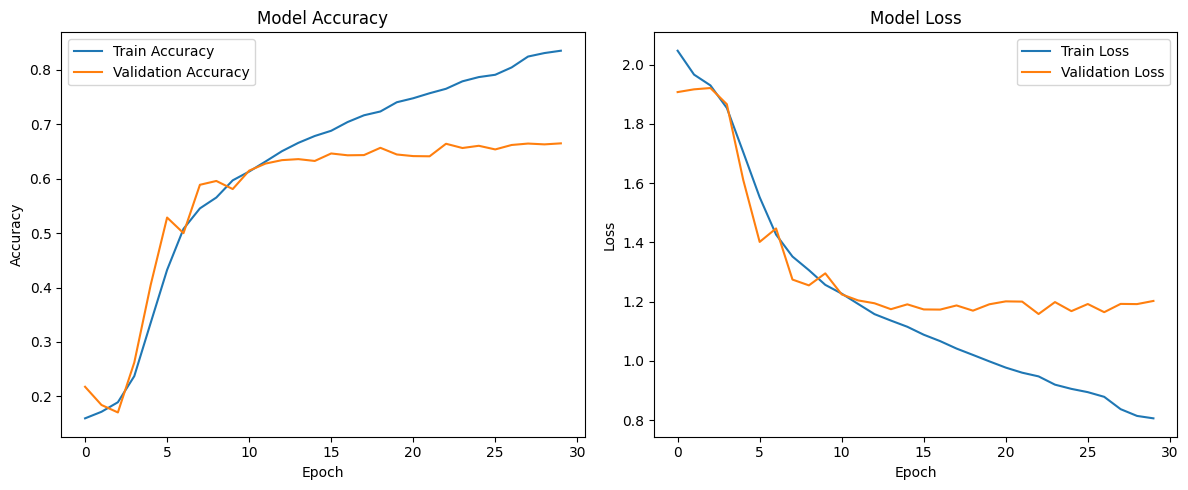

In [14]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracies["train accuracy"], label='Train Accuracy')
plt.plot(accuracies["valid accuracy"], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(losses['train loss'], label='Train Loss')
plt.plot(losses['valid loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [15]:
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=10, shuffle=True)

# Predict on test data
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6818


Classification Report:
              precision    recall  f1-score   support

     neutral       0.60      0.76      0.67       385
       happy       0.57      0.65      0.61       385
         sad       0.64      0.63      0.64       384
       angry       0.76      0.71      0.73       385
     fearful       0.68      0.50      0.58       385
     disgust       0.62      0.57      0.60       384
   surprised       0.95      0.94      0.94       385

    accuracy                           0.68      2693
   macro avg       0.69      0.68      0.68      2693
weighted avg       0.69      0.68      0.68      2693



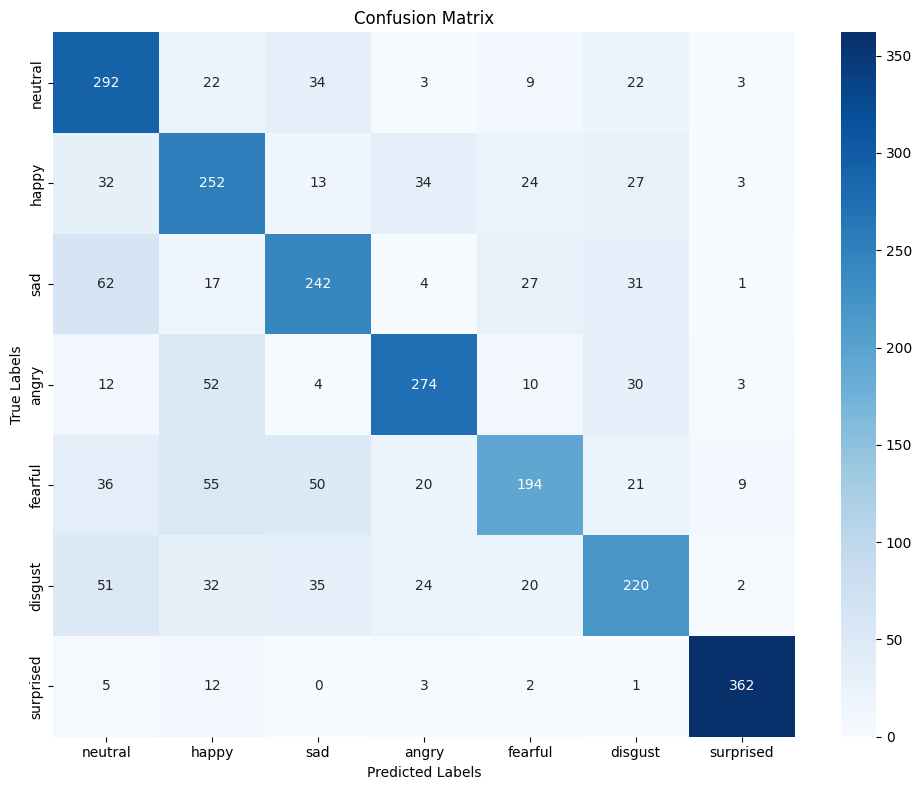

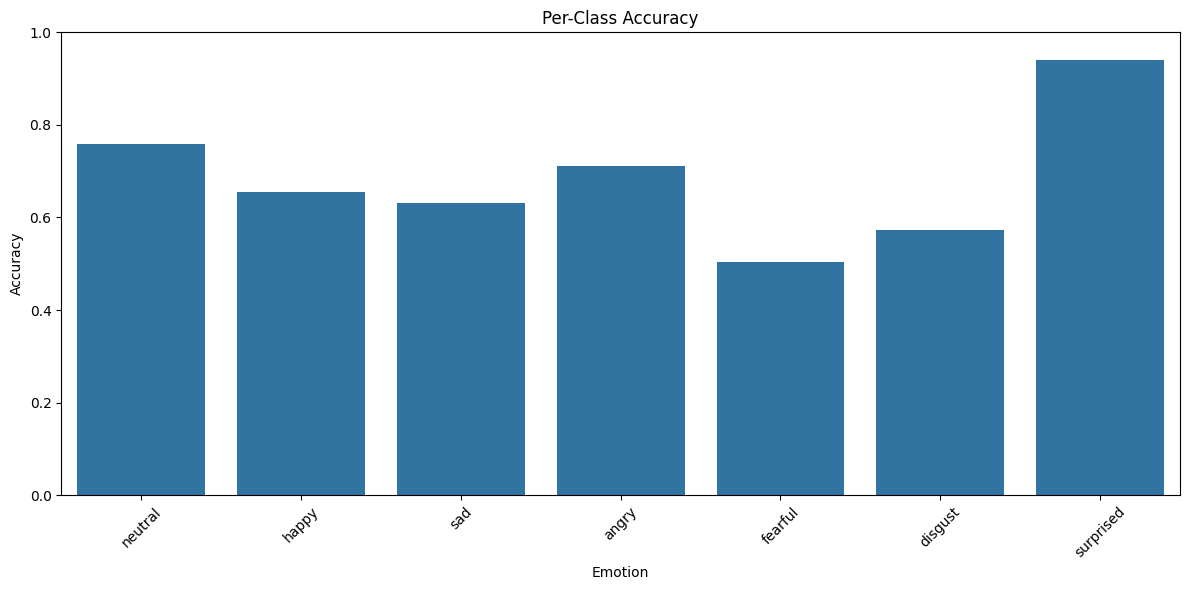

In [16]:
print("Classification Report:")
class_names = [reverse_mapping[i] for i in sorted(reverse_mapping.keys())]
report = classification_report(all_targets, all_preds, target_names=class_names)
print(report)

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy)
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()